<a href="https://colab.research.google.com/github/mingshey/python_mechanics/blob/main/Slope_and_Spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 경사면 + 용수철
마찰이 없는 경사면 위에 용수철이 경사 방향으로 놓여 있고 물체를 경사면 위의 일정 높이에서 가만히 놓았을 때의 운동.

<img src='https://drive.google.com/uc?export=download&id=17D-l24Q-2rhHKACuWadwwEFTWLPcBSo3' width="600" height ="146">

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 시스템 시간을 구하는 패키지
from time import gmtime, strftime

import pandas as pd

## 초기 상태 설정

In [ ]:
m = 1.0     # in [kg], 물체의 질량

g = 9.81    # [m/s^2] 중력 가속도
L = 1.0     # [m] 용수철의 자연 길이
K = 50.0   # [N/m] 용수철 상수
x1 = 1.0    # [m] 경사면 위 초기 위치
v1 = 0.0    # [m/s] 초기 속도

# 경사면의 기울기
angle = 20  # [도]([degree] 단위)
theta = angle*np.pi/180 # [rad] 단위로 변환
cth = np.cos(theta)     # 2번 이상 사용하는 계산 값은 매번 새로 계산하지 말고
sth = np.sin(theta)     # 변수에 저장하여 사용한다.

nofriction:bool = False
mu = 0.6                # 마찰 계수
F = mu * m * g * sth    # 마찰력의 크기
(A, B) = (0.1, 0.3)     # 마찰력이 작용하는 구간

sim_params = {'m':m, 'g': g, 'k': K, 'x1': x1, 'v1': v1, 'angle(deg)': angle,
              'nofriction': nofriction, 'mu': mu, 'fricA': A, 'fricB': B}

## 함수 정의

* 상태 변화율을 계산하는 함수:
용수철의 자연 길이 이하로 가까이 접근했을 때만 용수철의 압축에 따른 복원력이 작용하는 것으로 계산한다:

In [ ]:
def spring(x:float, k:float):
  if x <= 0.0:
    force = -k * x
  else:
    force = 0

  return force

In [ ]:
"""
spring 함수를 작성하는 또다른 방법
"""
# def spring(x:float, k:float):
#   return (1 - np.heaviside(x, 1.0)) * -k * x

'\nspring 함수를 작성하는 또다른 방법\n'

In [ ]:
"""
마찰력을 계산하여 반환하는 코드를 작성해 봅시다.

입력 값으로 (x, v) 를 나타내는 순서쌍 S와
마찰력의 크기 f0, 및 마찰력이 작용하는 구간 양 끝 위치 a, b를 인자로 받아
x 값이 a와 b 사이에 있으면 속도와 반대 방향으로 크기 f0인 힘을 반환하고
그렇지 않으면 0을 반환하도록 합니다.
(코드 작성 후 None은 삭제합니다.)
"""
def friction(S:tuple, f0:float, a:float, b:float):
  x, v = S
  if (x - a) * (x - b) < 0 and not nofriction:
    return -np.sign(v) * f0
  else:
    return 0

In [ ]:
def dSdt(t:float, S:tuple):
  """
  물체의 상태 S(x, v) 변화율을 계산한다.
  t: 는 시간.
  반환값:
  v=dx/dt,
  a=dv/dt
  """
  global m, g, K, sth, F, A, B
  x, v = S

  force = -m * g * sth
  force += spring(x, K)
  force += friction(S, F, A, B)

  a = force / m
  return np.array([v, a])

## 시뮬레이션

* 시뮬레이션을 수행할 시간 구간 및 간격:

In [ ]:
dt = 0.01 # in [s], simulation time interval
ti = 0.0
tf = 15.0
N = int(round((tf - ti)/dt))
ts = np.linspace(ti, tf, N+1)

* 시뮬레이션 실행:

In [ ]:
S0 = np.array([x1, v1])
sol1 = solve_ivp(dSdt, (ti, tf), S0, t_eval=ts, max_step=dt/20)

"""
다른 매개변수를 사용한 결과와의 충돌 방지를 위해
결과 저장시 파일 이름에 붙여줄 식별자.
시스템 시간을 이용함.
"""
simid = np.base_repr(int(strftime("%Y%m%d%H%M%S", gmtime())), 36)
simid

'76ADA2IHI'

* 결과를 분해하여 각 변수의 배열에 저장:

In [ ]:
ts = sol1.t

In [ ]:
xs, vs = sol1.y

* 시뮬레이션 파라미터들을 CSV 파일로 저장

In [ ]:
sp = pd.DataFrame(data=sim_params, index = [0])
sp.to_csv('sim-params-'+simid+'.csv')

* 시뮬레이션 결과(시간, 위치, 속도 값)을 CSV 파일로 저장

In [ ]:
d = {'t': ts, 'x': xs, 'v': vs}
df = pd.DataFrame(data = d)
df.to_csv('txv'+simid+'.csv')

## 결과 분석

**예상 최대 압축 거리(마찰이 없는 경우)**

초기 역학적 에너지: $E = mgx_1\sin\theta$.

용수철이 최대 $X$ 만큼 압축되었을 때($x=-X$) 순간 정지한다고 하면, 이 때 역학적 에너지는 $\frac{1}{2}kX^2-mgX\sin\theta$이므로$$\frac{1}{2}kX^2-mgX\sin\theta = mgx_1\sin\theta$$이고, 평형점을 $x=-x_0$ $\left(x_0 ≡\dfrac{mg\sin\theta}{k}\right)$라 하면, $$X^2-2 x_0 X = 2 x_0 x_1$$로부터,
$$ X = x_0 \pm \sqrt{(x_0 + x_1)^2 - x_1^2}$$

In [ ]:
# 예상 최대 압축 거리:
x0 = m * g * sth / K
X_theory = x0 + np.sqrt((x0 + x1)**2 - x1**2)
X_theory

0.4395445463993949

* 최대 압축 거리 비교

In [ ]:
print(f'X = {np.abs(xs.min()):.3f} m by simulation')

X = 0.417 m by simulation


### 위치-시간 그래프

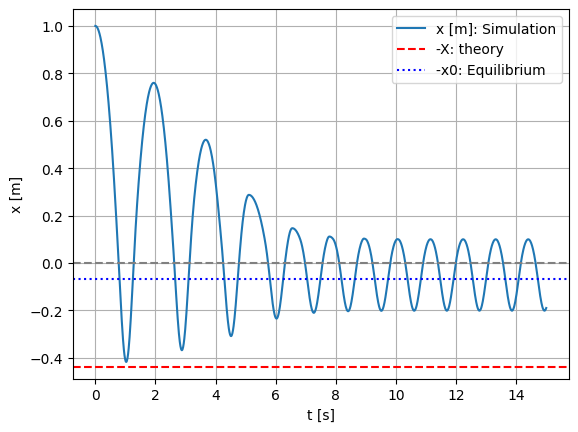

In [ ]:
plt.grid()
plt.xlabel("t [s]")
plt.ylabel("x [m]")

plt.plot(ts, xs, label="x [m]: Simulation")
plt.axhline(0, color='gray', ls = 'dashed')
plt.axhline(-X_theory, color='red', ls = 'dashed', label='-X: theory')
plt.axhline(-x0, color='blue', ls = 'dotted', label='-x0: Equilibrium')
plt.legend()
fname = 'x-vs-t-' + simid + '.png'
plt.savefig(fname, dpi=150)

### 용수철과 물체의 접촉 상태

In [ ]:
# 아래 코드의 contactq 값은 무슨 의미이고 어떤 값을 갖는지 알아봅시다.
contactq = (xs <= 0)

In [ ]:
"""
numpy.diff()를 이용하여 주어진 배열에서 이웃한 값들의 차이를 값으로 갖는 새로운 배열을
만드는 방법을 알아봅시다. 이렇게 만들어진 새로운 배열은 그 길이와 값이 원래 배열과 어떻게
다른지 확인해 봅시다.
contactq와 같이 논리 값을 갖는 배열에 numpy.diff()를 적용하면 어떤 배열이 만들어지는지
.dtype및  plt.plot()을 이용하여 알아봅시다.
"""

touching = np.diff(contactq)
touching = np.append(touching,[False])

"""
Boolean indexing (논리값 색인) 기법을 이용하여 배열에서 특정 조건을 만족하는 값만을
추출하는 방법을 알아봅시다; touching을 ts의 index(색인)로 사용하여 구한 tcs는 어떤 배열인지
조사해 보고 아래 코드에서 어떻게 사용되는지 알아봅시다.
"""
tcs = ts[touching]
tcs

array([ 0.77,  1.27,  2.62,  3.13,  4.25,  4.77,  5.74,  6.3 ,  6.97,
        7.55,  8.11,  8.7 ,  9.21,  9.81, 10.31, 10.9 , 11.39, 11.99,
       12.48, 13.07, 13.56, 14.15, 14.64])

### 속도-시간 그래프

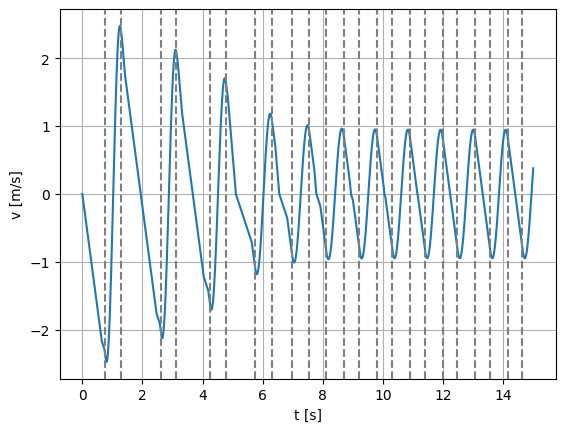

In [ ]:
"""
속도-시간 그래프에서 물체가 아래로 내려가는 과정에서 x값이 0이하 즉,
용수철과 접촉한 이후에도 잠시동안 속력이 증가하고,
또 올라가는 과정에서는 용수철에서 떨어지기 조금 전부터
속력이 감소하기 시작하는 이유를 설명해 봅시다.
"""

plt.grid()
#plt.xlim(0, 5)
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")

plt.plot(ts, vs)
for t in tcs:
  plt.axvline(t, c='gray', ls='dashed')

fname = 'v-vs-t-' + simid + '.png'
plt.savefig(fname, dpi=150)

### 에너지

* 탄성 퍼텐셜 에너지:

In [ ]:
"""
아래 코드에서 탄성 퍼텐셜 에너지를 구할 때 위에서 구한 contactq를 곱해줘야 하는 이유는 무엇이며
그 효과는 무엇인지 생각해 봅시다. 즉 contactq를 곱해주지 않으면 어떻게 될까요?
"""
PE1 = 0.5 * K * xs**2 * contactq

* 중력 퍼텐셜 에너지

In [ ]:
PE2 = m * g * sth * xs

* 운동 에너지:

In [ ]:
KE = 0.5 * m * vs**2

* 역학적 에너지:

In [ ]:
PE = PE1 + PE2
ME = PE + KE

#### 에너지-시간 그래프

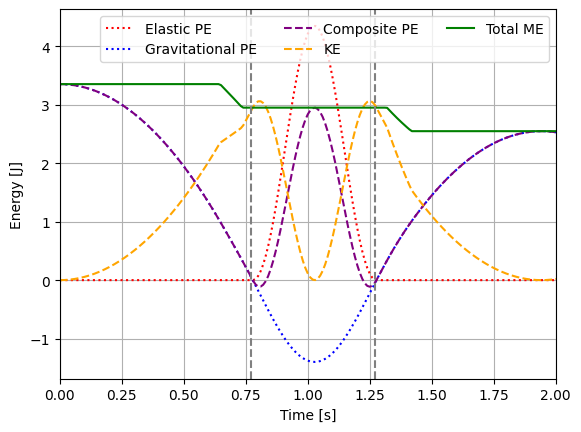

In [ ]:
plt.grid()
plt.xlim(0, 2)

plt.xlabel("Time [s]")
plt.ylabel("Energy [J]")
plt.plot(ts, PE1, c = 'red',    ls='dotted', label = "Elastic PE")       # 탄성 퍼텐셜 에너지
plt.plot(ts, PE2, c = 'blue',   ls = 'dotted', label = "Gravitational PE") # 중력 퍼텐셜 에너지
plt.plot(ts, PE,  c = 'purple', ls = 'dashed',  label = "Composite PE")     # 합성 퍼텐셜 에너지
plt.plot(ts, KE,  c = 'orange', ls='dashed',  label = "KE")               # 운동 에너지
plt.plot(ts, ME,  c = 'green',   ls = 'solid',  label = "Total ME")         # 역학적 에너지

for t in tcs:
  plt.axvline(t, c = 'gray', ls = 'dashed')

plt.legend(ncol=3)

fname = 'E-vs-t-' + simid + '.png'
plt.savefig(fname, dpi=300)

Text(0, 0.5, 'Energy [J]')

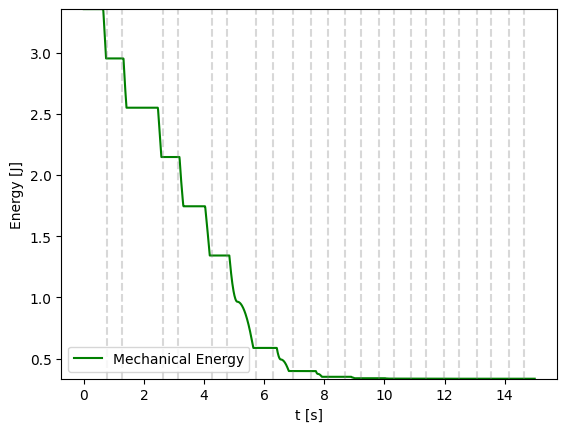

In [ ]:
plt.ylim(ME.min(), ME.max())
plt.plot(ts, ME, c='g', label="Mechanical Energy")
for t in tcs:
  plt.axvline(t, ls='--', c='gray', alpha=0.3)
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("Energy [J]")

#### 에너지-위치 그래프

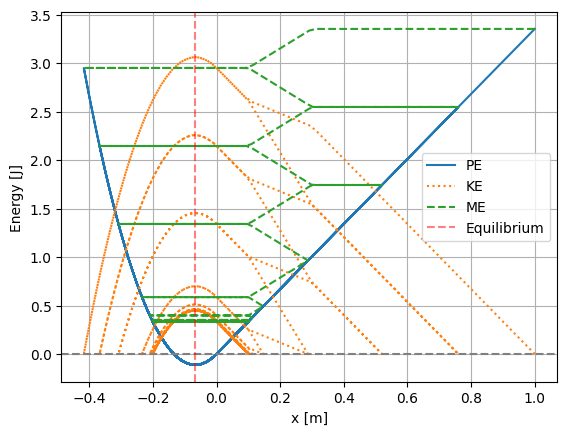

In [ ]:
plt.grid()
plt.plot(xs, PE, label = 'PE', ls = 'solid')
plt.plot(xs, KE, label = 'KE', ls = 'dotted')
plt.plot(xs, ME, label = 'ME', ls = 'dashed')
plt.xlabel('x [m]')
plt.ylabel('Energy [J]')
plt.axhline(0, color='gray', ls='dashed')
plt.axvline(-x0, color='red', ls='dashed', alpha=0.5, label="Equilibrium")
plt.legend()

fname = 'E-vs-x-' + simid + '.png'
plt.savefig(fname, dpi=300)

### 위상도 분석

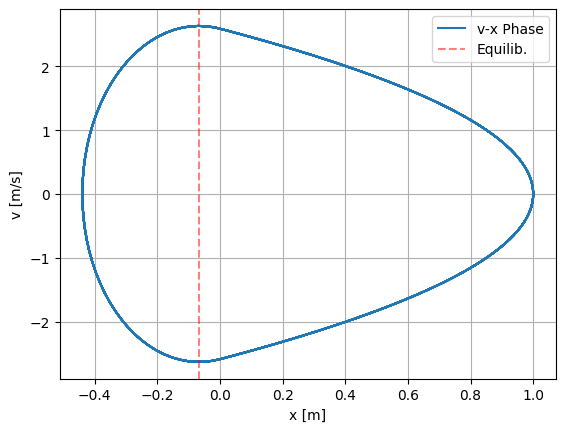

In [ ]:
plt.grid()
plt.plot(xs, vs, label="v-x Phase")
plt.xlabel("x [m]")
plt.ylabel("v [m/s]")
plt.axvline(-x0, color='red', ls='dashed', alpha=0.5, label='Equilib.')
plt.legend()

fname = 'v-x-phase-' + simid + '.png'
plt.savefig(fname, dpi=300)

In [ ]:
xcoord = np.linspace(-0.5, 1.0, 25)
vcoord = np.linspace(-3, 3, 25)
xp, vp = np.meshgrid(xcoord, vcoord)
rows, cols = np.shape(xp)
rows, cols

(25, 25)

In [ ]:
dxdts = np.array([[dSdt(t, [xp[i, j], vp[i, j]])[0] for j in range(cols)] for i in range(rows)])
dvdts = np.array([[dSdt(t, [xp[i, j], vp[i, j]])[1] for j in range(cols)] for i in range(rows)])

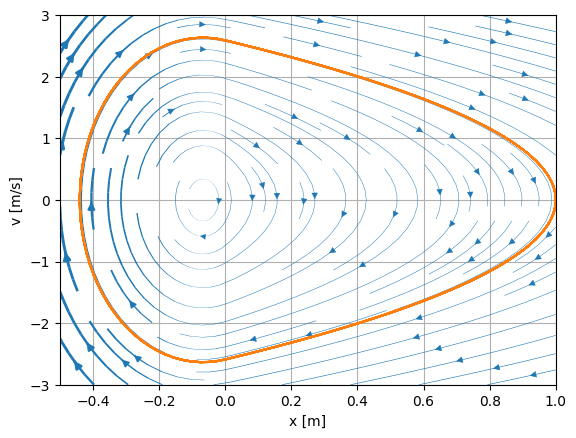

In [ ]:
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('v [m/s]')
#plt.quiver(xp, vp, dxdts, dvdts, angles='xy', scale_units='xy', scale=40)
plt.streamplot(xp, vp, dxdts, dvdts, linewidth=0.1*np.sqrt(dxdts**2+dvdts**2))

plt.plot(xs, vs)

# 그림 파일 저장
fname = 'phase-stream-' + simid + '.png'
plt.savefig(fname, dpi=300)

## 애니메이션 제작

동영상 제작은 부차적인 과정이지만, 시뮬레이션 결과에 이상한 오류가 없는지, 예상대로의 결과가 나왔는지 또는 예상과 다른 의외의 결과가 있는지 등을 확인하고 이에 대한 토의 과정을 위해 사용할 수 있다.

In [ ]:
import matplotlib.patches as patches
import matplotlib.animation as anim
from matplotlib.animation import PillowWriter

In [ ]:
def make_spring(begin, end, windings=10, res=4, r=0.1, head=0, tail=0, l0=1, psi=0, left_handed=False):
  '''
  ## 3차원 공간 속의 용수철을 나타내는 점 배열을 계산한다.
  (begin) _____/\  /\  /\  /\  /\  /\  /\  _____ (end)
                 \/  \/  \/  \/  \/  \/  \/
           head           coil              tail

  ### 매개변수:
  * begin: 용수철의 시작점(3차원 좌표), 길이 3인 numpy.ndarray
  * end:   용수철의 끝점(3차원 좌표), 길이 3인 numpy.ndarray
  * windings: [Integer] 코일의 감은 수
  * res:   [Integer] 해상도. 1번 감을 때 점의 수. 기본 = 4
  * rad:   [Number] 용수철의 반지름. 기본=0.1
  * head:  [Number] 용수철 시작 부분의 감지 않은 직선 부분 길이
  * tail:  [Number] 용수철 끝 부분의 감지 않은 직선 부분 길이
  * psi:   [Number] 축을 중심으로 회전한 각(rad), 기본 = 0
  * left_handed: [Boolean] 왼쪽으로 감긴 용수철, 기본 = False

  ### 반환값:
  * ndarray(n, 3) 용수철 와이어를 따라 위치한 각 점의 좌표 배열
  '''
  pi2=2*np.pi
  vec = end - begin
  l = np.sqrt((vec * vec).sum())

  # 와이어 길이가 보존되도록 반지름 값을 계산
  rad = np.sqrt(r**2-(l**2-l0**2)/(pi2*windings)**2)

  # 용수철 방향 단위 벡터
  u = vec / l

  # 코일 영역 길이
  l1 = l - head - tail

  # 코일 영역의 매개변수 계산
  ths = np.arctan2(np.sqrt(u[0]**2+u[1]**2), u[2])
  phs = np.arctan2(u[1], u[0])
  sgn = -1 if left_handed else 1

  # u에 수직인 xy-평면상의 단위 벡터
  v = np.array([-np.sin(phs), np.cos(phs),0])

  # u, v에 수직인 단위 벡터
  w = np.array([u[1]*v[2]-u[2]*v[1], u[2]*v[0]-u[0]*v[2], u[0]*v[1]-u[1]*v[0]])*sgn

  pts = begin # 시작점
  if head > 0:
    pts = np.append(pts, u*head) # 코일 시작 부분, 중심 축 위의 점

  # 코일 부분의 표본 매개변수(sampling parameter)
  t = np.linspace(0, 1, windings * res + 1)

  # 코일 부분 와이어 위의 좌표
  s = np.array( [pts[-3:] + l1 * t1 * u +
                np.cos(pi2 * windings * t1) * rad * v +
                np.sin(pi2 * windings * t1) * rad * w for t1 in t])
  s = s.reshape(1, len(t) * 3)

  pts = np.append(pts, s)                       # 코일 부분
  pts = np.append(pts, begin + u * (head + l1)) # 코일 끝, 중심 축 위의 점
  if tail > 0:
    pts = np.append(pts, begin + l * u) # 끝 부분 직선 영역
  n = len(pts) // 3
  return pts.reshape(n, 3)

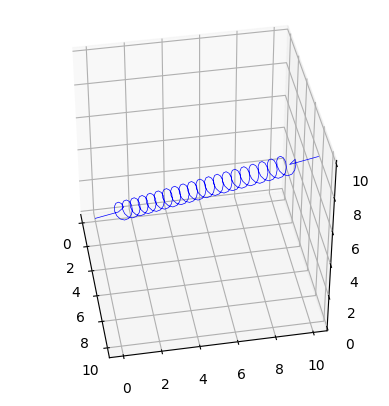

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.view_init(elev=40., azim=-10, roll=0)

spr = make_spring(np.array([0,0,0]), np.array([10,10,10]),
                    head=2, tail=2, r=0.5, windings=20, l0=15, res = 12)
xspr, yspr, zspr = spr.T
ax.plot(xspr, yspr, zspr, color='blue', lw=0.5)

애니메이션 출력 시간을 줄이기 위해 프레임 수를 줄인다.

In [ ]:
ts1 = sol1.t[::5]
xs1, vs1 = sol1.y[:, ::5]
N=len(ts1)
N

301

In [ ]:
def frame(k):
  box_w = 0.03
  box_h = 0.04
  extend = 1.2
  ax.cla()
  ax.set_xlim(-L * 1.05 * cth, extend * x1 * cth)
  ax.set_ylim(-L  * sth, 1.3 * x1 * sth)
  ax.set_title(f'{ts1[k]:.2f} s')

  # 물체.
  ax.add_patch( patches.Rectangle((xs1[k]*cth, xs1[k]*sth), box_w, box_h,
                                  color='orange', angle=angle))

  # 마찰 구간
  if not nofriction:
    ax.add_patch( patches.Rectangle((A*cth, A*sth), B-A, -box_h, color='lightgray', angle=angle))

  # 용수철
  sprb = -L*np.array([cth, sth, 0])+box_h/2*np.array([-sth, cth, 0])
  spre = min([0, xs1[k]]) * np.array([cth, sth, 0]) +\
         box_h/2 * np.array([-sth, cth, 0])
  spr = make_spring(sprb, spre, r=L/100, windings=50, l0=5/4*L, res = 12)
  xspr, yspr, zspr = spr.T
  ax.plot(xspr, yspr, color='blue', lw=0.5)

  # 경사면
  ax.plot([-L * cth, extend * x1 * cth],
   [-L * sth, extend * x1 * sth],
          c='black')
  ax.plot([-L * cth, -L * cth - box_h * sth],
   [-L * sth, -L * sth + box_h * cth],
          c='black')

  # 눈금자
  for x in np.arange(-L, extend * x1, 0.1):
    ticx1 = x * cth
    ticy1 = x * sth
    ticx2 = ticx1 + (L / 30) * sth
    ticy2 = ticy1 - (L / 30) * cth
    ax.plot([ticx1, ticx2], [ticy1, ticy2], lw = 0.3, c='black')
  for x in np.arange(-1.0, extend * x1, 0.5):
    ticx1 = x * cth
    ticy1 = x * sth
    ticx2 = ticx1 + (L / 20) * sth
    ticy2 = ticy1 - (L / 20) * cth
    ax.plot([ticx1, ticx2], [ticy1, ticy2], lw = 0.5, c='black')
  ax.plot([0, (L / 15) * sth], [0, -(L / 15) * cth], lw=1, c='r')
  #fig.show()

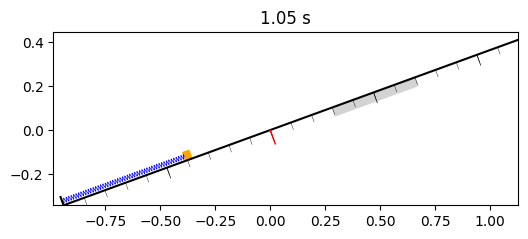

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_aspect('equal')
frame(21)

fname = "slope-and-spring" + simid + ".png"
plt.savefig(fname, dpi=150)

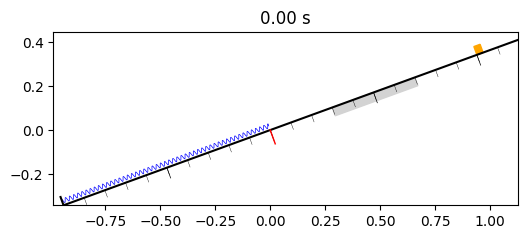

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_aspect('equal')
ani = anim.FuncAnimation(fig, frame, frames=N)

In [ ]:
# Save as an MPEG movie
fname = 'slope-and-spring-' + simid + '.mpeg'
ani.save(fname, dpi=150, fps=20)

In [ ]:
# Save as an animated GIF figure.
fname = 'slope-and-spring-' + simid + '.gif'
ani.save(fname, writer='pillow', dpi=150, fps=20)